In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import statistics
from sklearn import metrics
df = pd.read_excel("SupplyChain_TimeSeriesData.xlsx") #input the file

Importing plotly failed. Interactive plots will not work.


In [2]:
#Create colummns for actual duration and scheduled duration
df['scheduled_duration_nowkend'] = df.apply(lambda row: pd.bdate_range( row['Schedule Start Date'], row['Schedule Finish Date']).shape[0] \
                                            if not pd.isna(row['Schedule Start Date']) and not pd.isna(row['Schedule Finish Date']) else np.nan, axis=1 )
df['actual_duration_nowkend'] = df.apply(lambda row: pd.bdate_range( row['Confirmation Start Date'], row['Usage Decision Date']).shape[0] \
                                         if not pd.isna(row['Confirmation Start Date']) and not pd.isna(row['Usage Decision Date']) else np.nan, axis=1 )

In [3]:
#Put df in chronological order
df = df.sort_values("Confirmation Start Date", ascending = 1)
df = df.dropna(subset=['Confirmation Start Date', 'Usage Decision Date'])

In [36]:
unique_group = pd.unique(df["Group"])
unique_group.sort()
unique_group
newDataSet = pd.DataFrame()

for value in unique_group:
    group = df.loc[(df["Group"] == value)] #group == 106, 100001064, 100001522, 100001520
    group = group.loc[group["actual_duration_nowkend"] > 0]
   # group.set_index("Confirmation Start Date", inplace = True)
    group = group.sort_values("Confirmation Start Date")
    group["per"] = group['Confirmation Start Date'].dt.to_period("M")
    
    if len(group) > 1:
        three_sigma = statistics.stdev(group['actual_duration_nowkend']) * 3
        group = group[group['actual_duration_nowkend'] <= three_sigma]
    
    
        dates = pd.unique(group["per"])
        # empty is an empty dataframe that I am adding rows to at the end of the for-loop

        for month in dates:
            df_month = group.loc[group["per"] == month]

            #Looking at Outliers
            q1 = df_month.quantile(0.25)[0]
            q2 = df_month.quantile(0.50)[0]
            q3 = df_month.quantile(0.75)[0]

            IQR = q3 - q1
            lower = q1 - 1.5*IQR
            upper = q3 + 1.5*IQR

            temp = df_month[(df_month["actual_duration_nowkend"] < upper)]
            temp['ds'] = df_month.index
            newDataSet = newDataSet.append(temp)



In [37]:
#X: input features
#Y: target variable 

X = newDataSet[['Group', 'MaterialCategory', 'Material', 'Total order quantity', 'Confirmation Start Date',]]
Y = newDataSet['actual_duration_nowkend']

In [38]:
#Training Data for Prophet

pro_df = pd.DataFrame()
pro_df['ds'] = X['Confirmation Start Date']
pro_df['y'] = Y

In [39]:
#Prophet Model with multiple regressors

pro_df['Material'] = X['Material']
pro_df['Group'] = X['Group']
pro_df['MaterialCategory'] = X['MaterialCategory']
pro_df['Total order quantity'] = X['Total order quantity']

pro_df = pro_df.sort_values(by = 'ds')

In [40]:
pro_df.shape

(32592, 6)

In [41]:
train_df = pro_df[ : 26073]
test_df = pro_df[26073 : ]

In [63]:
r = Prophet(yearly_seasonality = True, daily_seasonality = True, changepoint_prior_scale = 0.50)
r.add_regressor('Material')
r.add_regressor('Group')
r.add_regressor('MaterialCategory')
r.add_regressor('Total order quantity')


r.fit(train_df)

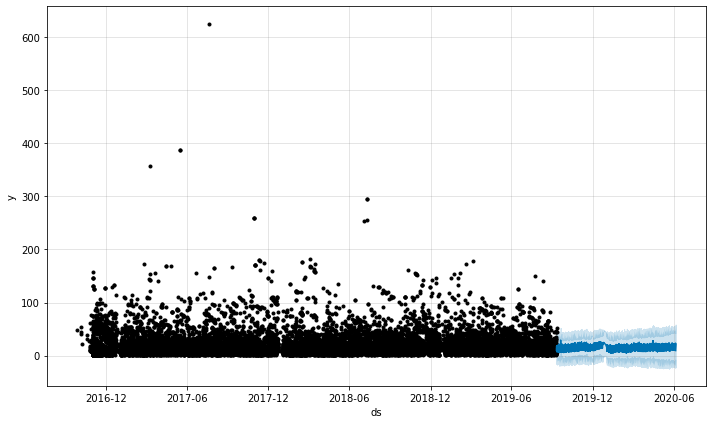

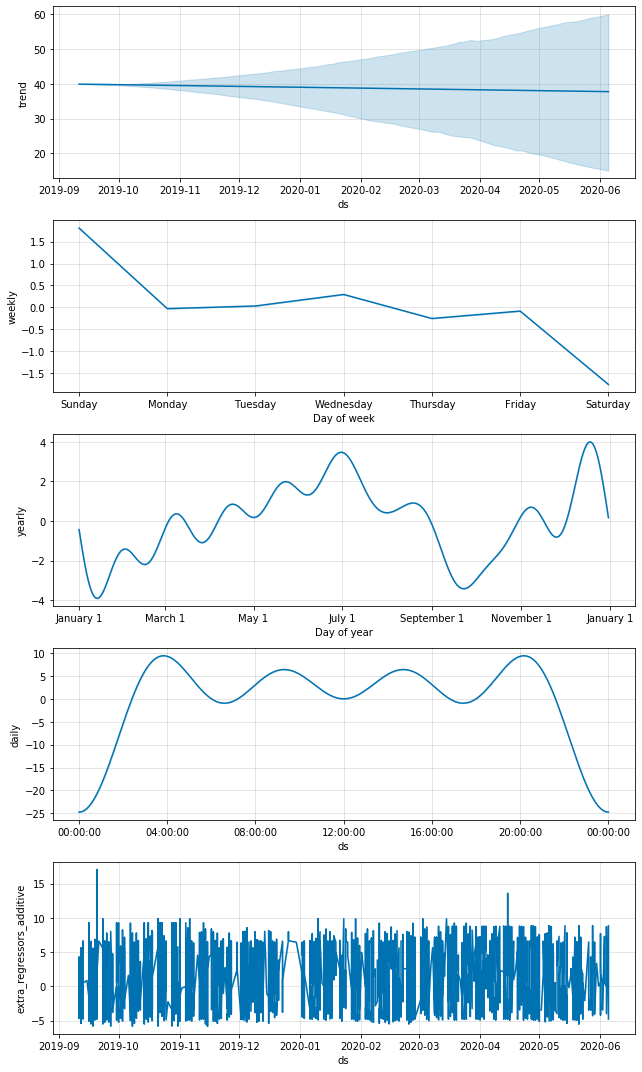

In [64]:
forecast_r = r.predict(test_df) 

fig3 = r.plot(forecast_r) 
fig4 = r.plot_components(forecast_r)

In [66]:
#Calculating Accuracy using MSE 

mse = metrics.mean_squared_error(test_df['y'], forecast_r['yhat'], squared=True)
print(mse)

153.9221010906702
